# 3. Temporal GP inference using the Kalman filter/smoother

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import plot
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary
import pandas as pd
from functools import partial
from dataclasses import dataclass, field
from typing import Tuple, Callable
import time

Temporal data (i.e. data lying on the real line) in Gaussian processes regression is special as it can be processed at a mere $\mathcal{O}(N)$ cost compared to the usual $\mathcal{O}(N^3)$ cost (see e.g. [Särkkä et al. 2013](https://users.aalto.fi/~ssarkka/pub/inf-bayes-draft.pdf) and [Hartikainen et al. 2010](https://ieeexplore.ieee.org/document/5589113)). In fact, it was also [shown recently](https://arxiv.org/abs/2102.09964) that if we utilise the GPU, one can even reduce this cost further down to sub-linear time!

The reason for this is that in the temporal dimension, GPs can be expressed or at least approximated by a linear stochastic differential equation (SDE) with additive noise and the latter can process the data sequentially using the Kalman filter/smoother, which scales only linearly with the number of datapoints (details on Kalman filter/smoother can be found in the appendix of this notebook).

In this section of the tutorial, we will see how this is done by extrapolating the global temperature time series data using a Matérn GP.

In [2]:
# Below is an implementation of the Kalman filter/smoother
class KalmanFilterSmoother():
    def __init__(self, F, Q, H, R):
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        
    def _predict(self, x, P):
        F = self.F
        Q = self.Q
        return tf.linalg.matvec(F, x), F@tf.linalg.matmul(P, F, transpose_b=True) + Q

    def _filter_update(self, x, P, y):
        R = self.R
        H = self.H
        # Compute Kalman gain matrix
        if not tf.math.is_nan(y):
            S = H @ tf.linalg.matmul(P, H, transpose_b=True) + R
            chol = tf.linalg.cholesky(S)
            Kt = tf.linalg.cholesky_solve(chol, H@P)
            Hx = tf.linalg.matvec(H, x)
            return x + tf.linalg.matvec(Kt, y - Hx, transpose_a=True), P - tf.linalg.matmul(Kt, S, transpose_a=True) @ Kt
        else:
            return x, P

    def _smoother_update(self, x_now, x_next, x_forecast, P_now, P_next, P_forecast):
        F = self.F
        # Compute smoothing gain
        chol = tf.linalg.cholesky(P_forecast)
        Jt = tf.linalg.cholesky_solve(chol, F @ P_now)
        # Update
        xnew = x_now + tf.linalg.matvec(Jt, x_next - x_forecast, transpose_a=True)
        Pnew = P_now + tf.linalg.matmul(Jt, P_next - P_forecast, transpose_a=True) @ Jt
        return xnew, Pnew

    def forward_pass(self, x, P, y_list):
        """ Calling the forward pass gives us the filtering distribution.
            Args:
                x: numpy array of shape (d,) where d is the spatial dimension
                P: numpy array of shape (d, d)
                y_list: numpy array of shape (N, d) containing a list of observations at N timepoints.
                        Note that when there is no observation at time n, then set y_list[n] = np.nan
        """
        means = []
        covariances = []
        for y  in y_list:
            x, P = self._filter_update(x, P, y)
            means.append(x)
            covariances.append(P)
            x, P = self._predict(x, P)
        return tf.stack(means), tf.stack(covariances)

    def backward_pass(self, x, P):
        """ Calling the backward pass gives us the smoothing distribution. This should be called after applying the forward pass.
            Args:
                x: numpy array of shape (N, d) where N is the number of forward time steps and d is the spatial dimension
                P: numpy array of shape (N, d, d)
        """
        F = self.F
        N = x.shape[0]
        means = [x[-1]]
        covariances = [P[-1]]
        for n in range(N-2, -1, -1):
            # Forecast
            xf, Pf = self._predict(x[n], P[n])
            # Update
            xnew, Pnew = self._smoother_update(x[n], x[n+1], xf, P[n], P[n+1], Pf)
            means.append(xnew)
            covariances.append(Pnew)
        return tf.reverse(tf.stack(means), tf.constant([0])), tf.reverse(tf.stack(covariances), tf.constant([0]))

    def __call__(self, x0, P0, y_list):
        """ Compute the smoothing distribution by applying the forward and backward pass in sequence.
            Args: same as in self.forward_pass
        """
        x, P = self.backward_pass(*self.forward_pass(x0, P0, y_list))
        return x, P


@dataclass
class PlotConfig:
    figsize: tuple = (10,8)
    xlabel: str = "Date"
    xlabel_kwargs: dict = field(default_factory=lambda: {"fontsize": 14})
    ylabel: str = "Global surface temperature anomaly (°C)"
    ylabel_kwargs: dict = field(default_factory=lambda: {"fontsize": 14})
    title: str = None
    title_kwargs: dict = field(default_factory=lambda: {"fontsize": 14})
    xticks_position: Tuple[list, np.ndarray] = np.arange(19.0, 21.5, 0.5)
    xticks_label: Tuple[list, np.ndarray] = np.arange(1900, 2150, 50)
    grid_on: bool = True
    grid_kwargs: dict = field(default_factory=lambda: {"linestyle": '--', "linewidth": 0.5})


def plot_wrapper(
        plot_config: PlotConfig,
        plot_args,
        plot_kwargs,
        plot_fn: Callable
    ):
    plot_fn(*plot_args, **plot_kwargs)
    if plot_config.grid_on:
        plt.grid(**plot_config.grid_kwargs)
    ax = plt.gca()
    ax.set_xlabel(plot_config.xlabel, **plot_config.xlabel_kwargs)
    ax.set_ylabel(plot_config.ylabel, **plot_config.ylabel_kwargs)
    ax.set_xticks(plot_config.xticks_position)
    ax.set_xticklabels(plot_config.xticks_label)
    ax.set_title(plot_config.title, **plot_config.title_kwargs)


plot_timeseries = partial(plot_wrapper, plot_fn=plot)


We use NASA's global surface temperature anomaly timeseries data, which can be found [here](https://data.giss.nasa.gov/gistemp/). The raw data was pre-processed following [this tutorial](https://towardsdatascience.com/time-series-analysis-and-climate-change-7bb4371021e).

In [3]:
# Load global temperature data
df = pd.read_csv("data/NASA_global_temperature_anomalies.csv")
df['date'] = pd.to_datetime(df['date'])
print(df.head())
print(df.tail())

        date  Avg_Anomaly_deg_C
0 1880-01-31              -0.29
1 1880-02-29              -0.18
2 1880-03-31              -0.11
3 1880-04-30              -0.20
4 1880-05-31              -0.12
           date  Avg_Anomaly_deg_C
1675 2019-08-31                0.9
1676 2019-09-30                0.9
1677 2019-10-31                0.9
1678 2019-11-30                0.9
1679 2019-12-31                0.9


In [4]:
# Generate additional months until year 2100 as test points for GP extrapolation
startdate = df["date"].iloc[0]
enddate = '1/01/2100'
X = pd.date_range(start=startdate, end=enddate, freq='M').map(pd.Timestamp.toordinal).to_numpy()
X = X[:, None]

In [5]:
# Use the entire data for training
X_train = df['date'].map(pd.Timestamp.toordinal) # We store the date in ordinal form instead of datetime to do regression
X_train = X_train.to_numpy()[:, None]
Y_train = df["Avg_Anomaly_deg_C"]
Y_train = Y_train.to_numpy()[:, None]

Below, we rescale the date so that 1 unit = 100 years. While this is not really necessary in GP regression (just set the lengthscale accordingly), when applying Kalman filtering later, consecutive data points should be spaced at small intervals relative to the unit in order for it to work.

In [6]:
# Rescale ordinal date so that 1 unit = 100 years
unit = 365.24*100
X = X/unit
X_train = X_train/unit

We first extrapolate the data using the standard approach in GP regression.

In [7]:
# Set up Matern GP
ls = 3.0
amp = 1.5
obs_var = 0.2**2

Matern32 = gpflow.kernels.Matern32(variance=amp**2, lengthscales=ls)
m = gpflow.models.GPR(data=(X_train, Y_train), kernel=Matern32, mean_function=None)
m.likelihood.variance.assign(obs_var)

print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    2.25 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    3    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │    0.04 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [8]:
# GP prediction
start = time.time()
mean, var = m.predict_f(X)
stop = time.time()
elapsed = stop-start
print(f"time elapsed: {elapsed:.2f}s")


time elapsed: 4.15s


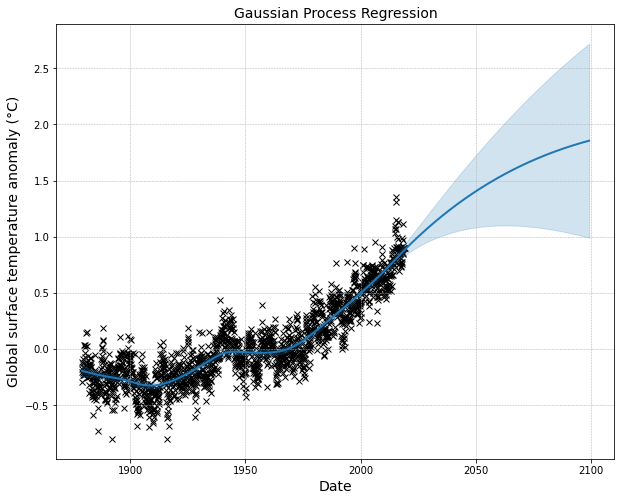

In [9]:
# Plot timeseries for GPR
config = PlotConfig(title="Gaussian Process Regression")
plot_timeseries(config,
                plot_args=(X, mean, var),
                plot_kwargs={"data": (X_train, Y_train), "figsize": (10, 8)})

## GP regression via Kalman filtering/smoothing

We now look at the SDE representation of the Matérn GP with $\nu = 3/2$, which can be found in [Hartikainen et al. 2010](https://ieeexplore.ieee.org/document/5589113). The Matérn-3/2 kernel has the functional form
\begin{align*}
k_{3/2}(t, t') = \sigma^2 \left(1+\frac{\sqrt{3}|t-t'|}{l}\right)\exp\left(-\frac{\sqrt{3}|t-t'|}{l}\right).
\end{align*}

Given $f \sim \mathcal{GP}(0, k_{3/2}(\cdot, \cdot))$, we can express this stochastic process equivalently as the SDE (using physics notation)

\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t}
\begin{pmatrix}
f(t) \\ \dot{f}(t)
\end{pmatrix}
=
\begin{pmatrix}
0 & 1 \\
-\lambda^2 & -2\lambda
\end{pmatrix}
\begin{pmatrix}
f(t) \\ \dot{f}(t)
\end{pmatrix}
+
\begin{pmatrix}
0 \\ 1
\end{pmatrix}
w(t),
\end{align*}

where
\begin{align*}
\lambda := \sqrt{3}/l
\end{align*}

and $w(t)$ is a Gaussian white noise process with spectral density

\begin{align*}
q = 4 \sigma^2 \lambda^3.
\end{align*}

As a sidenote, this process is equivalent to the harmonic oscillator Langevin equation studied in physics.

### Initial condition
To determine the initial conditions of the SDE above, we go back to the original GP formulation. The initial condition $(f(0), \dot{f}(0))$ of the SDE should in principle be a random variable in both the position and velocity space (i.e. the time derivative) such that the position component is equivalent in distribution to the GP prior at $t=0$. That is,
\begin{align*}
f(0) \sim \mathcal{N}(0, \sigma^2).
\end{align*}
To find the distribution on the derivative component, we note that by linearity,
\begin{align*}
\text{Cov}[\dot{f}(t), \dot{f}(t')] = \frac{\mathrm{d}}{\mathrm{d}t} \frac{\mathrm{d}}{\mathrm{d}t'} \text{Cov}[f(t), f(t')] = \frac{\mathrm{d}}{\mathrm{d}t} \frac{\mathrm{d}}{\mathrm{d}t'} k_{3/2}(t, t'),
\end{align*}
the latter which is known as the *derivative kernel*. Setting $t > t'$ without loss of generality, we have
\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t} |t - t'| = \frac{\mathrm{d}}{\mathrm{d}t'} |t - t'| = 1,
\end{align*}
which gives us
\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t} \frac{\mathrm{d}}{\mathrm{d}t'} k_{3/2}(t, t') = \frac{3\sigma^2}{l^2} \left(1+\frac{\sqrt{3}|t-t'|}{l}\right)\exp\left(-\frac{\sqrt{3}|t-t'|}{l}\right).
\end{align*}
Thus, taking the limit $t' \rightarrow t$, we see that
\begin{align*}
\text{Var}[\dot{f}(t)] = 3\sigma^2/l^2 = \sigma^2 \lambda^2,
\end{align*}
for all $t \in \mathbb{R}$ and therefore also $t = 0$. Puttting this together, we have the initial condition
\begin{align*}
\begin{pmatrix}
f(0) \\ \dot{f}(0)
\end{pmatrix} \sim 
\mathcal{N}
\left(
\begin{pmatrix}
0 \\ 0
\end{pmatrix},
\begin{pmatrix}
\sigma^2 & 0 \\ 0 & \sigma^2 \lambda^2
\end{pmatrix}
\right).
\end{align*}

### Discretisation and state-space representation
We can discretise the SDE in any way we wish. While it is usually better to choose a higher order scheme to accurately approximate the SDE, for ease of demonstration, we will use the Euler-Maruyama scheme in this notebook, which is order 1/2 (i.e., very bad). See for e.g. [this book](https://users.aalto.fi/~asolin/sde-book/sde-book.pdf) on details of other discretisation schemes.

The Euler-Maruyama discretisation of the SDE above is given as follows:

\begin{align*}
X_{n+1} &= X_n + A X_n \Delta t_n + \sqrt{q \Delta t_n} \,L \,\xi_n, \quad \xi_n \sim \mathcal{N}(0, I)  \\
&= (I + A \Delta t_n) X_n + \sqrt{q \Delta t_n} \,L \,\xi_n,
\end{align*}

where
\begin{align*}
X_n :=
\begin{pmatrix}
f(t) \\ \dot{f}(t)
\end{pmatrix}, \quad
A :=
\begin{pmatrix}
0 & 1 \\ -\lambda^2 & -2\lambda
\end{pmatrix},
\quad \text{and} \quad
L :=
\begin{pmatrix} 
0 \\ 1
\end{pmatrix}.
\end{align*}

Thus, the state-space representation of the filtering/smoothing problem is given as
\begin{align*}
X_{n+1} &= F_n X_n + \zeta_n, \quad \zeta_n \sim \mathcal{N}(0, Q_n) \\
y_n &= H X_n + \eta_n, \quad \eta_n \sim \mathcal{N}(0, R),
\end{align*}
where
\begin{align*}
F_n := (I + A \Delta t_n), \quad \quad Q_n := L(q\Delta t_n)L^T, \quad H := (1, 0), & \quad \text{and} \quad R := \sigma_{\text{obs}}^2.
\end{align*}

With these notations in mind and taking $\Delta t_n$ to be the distance between two consecutive data points, we set up the state-space model below.

In [10]:
# Set timestep to be mean of consecutive timesteps between data 
dts = X_train[1:] - X_train[:-1]

# Really, one should use the individual dts and discretise the SDE with variable timesteps but for demonstration purpose, we use a uniform timestep given by its mean.
dt = dts.mean()

# Set up state space model
lambda_ = np.sqrt(3) / ls
A = np.array([[0., 1.], [-lambda_**2, -2*lambda_]])
L = np.array([[0.], [1.]])
F = np.eye(2) + A*dt
q = 4*amp**2*lambda_**3
Q = np.array([[0., 0.], [0., q*dt]])
H = np.array([[1., 0.]])
R = np.array([[obs_var]])

# Initialize
x = np.array([0., 0.])
P = np.array([[amp**2, 0.], [0., amp**2*lambda_**2]])

In [11]:
# Set up observations to feed into the Kalman filter. We set y = np.nan where there are no observations (i.e. test points)
Y = np.empty(X.shape)
Y[:] = np.nan
training_size = Y_train.shape[0]
Y[:training_size] = Y_train

Next we apply the Kalman filter to the state-space system. We refer to the appendix below for more details on the Kalman filter algorithm.

In [12]:
# Apply Kalman filter
f = KalmanFilterSmoother(F, Q, H, R)
start = time.time()
x_list, P_list = f.forward_pass(x, P, Y)
stop = time.time()
elapsed = stop-start
print(f"time elapsed: {elapsed:.2f}s")

time elapsed: 4.15s


We don't see a massive improvement in inference time with data of this size. However, notable gain in speed should be observed as the data size grows.

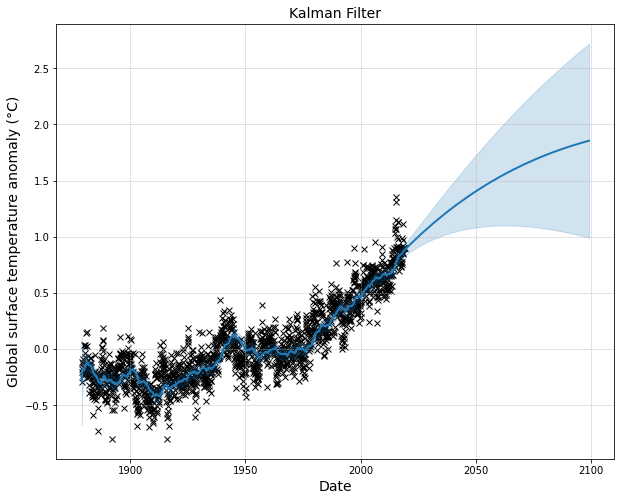

In [13]:
var_list = P_list[:, 0, 0]
f_list = x_list[:,0]

config.title = "Kalman Filter"
plot_timeseries(config,
                plot_args=(X, f_list[:, None], var_list[:, None]),
                plot_kwargs={"data": (X_train, Y_train), "figsize": (10, 8)})

The above result looks similar to the results from GP regression, except that in the Kalman filter case, the predictions are quite jagged where there are data. We believe that this is due to discretisation error - the GP and SDE are equivalent at a continuous level, however to apply the filter, we had to approximate the SDE by a discrete model.

Below, we look at what happens when we apply the Kalman smoother (see appendix), which is done by applying the backward pass to the results from the Kalman filter.

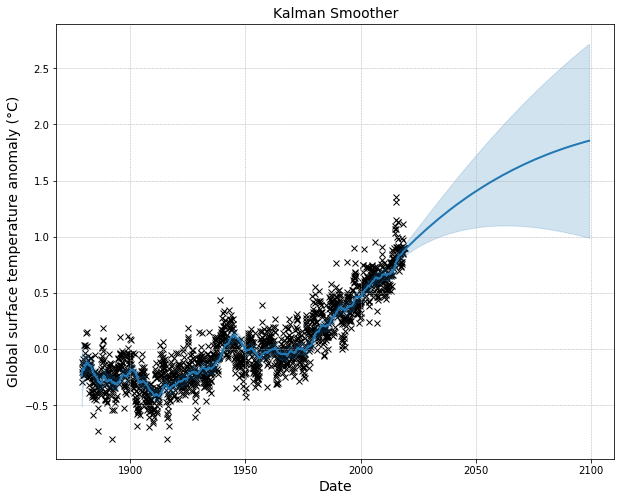

In [14]:
# Apply Kalman smoother
x_list, P_list = f.backward_pass(x_list, P_list)
var_list = P_list[:, 0, 0]
f_list = x_list[:,0]

# Plot
config.title = "Kalman Smoother"
plot_timeseries(config,
                plot_args=(X, f_list[:, None], var_list[:, None]),
                plot_kwargs={"data": (X_train, Y_train), "figsize": (10, 8)})

Applying the backward pass (i.e. smoothing) did not make much visible difference.

## Create animation for talk

In [15]:
from celluloid import Camera
from functools import partial

In [16]:
# Set up sparse GP with training inputs collocated at inducing point locatiosn
kernel = gpflow.kernels.Matern32(variance=amp**2, lengthscales=ls)

M = 250  # Number of inducing locations
Z = tf.random.shuffle(X_train)[:M]
num_train_data = X_train.shape[0]

sparse_gp = gpflow.models.SVGP(kernel=kernel, likelihood=gpflow.likelihoods.Gaussian(), inducing_variable=Z, num_data=num_train_data)
sparse_gp.likelihood.variance.assign(obs_var)
gpflow.set_trainable(sparse_gp.kernel.variance, False)
gpflow.set_trainable(sparse_gp.kernel.lengthscales, False)
gpflow.set_trainable(sparse_gp.likelihood.variance, False)
gpflow.set_trainable(sparse_gp.inducing_variable.Z, False)
print_summary(sparse_gp)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤═════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value               │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪═════════════════════╡
│ SVGP.kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()            │ float64 │ 2.25                │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼─────────────────────┤
│ SVGP.kernel.lengthscales │ Parameter │ Softplus         │         │ False       │ ()            │ float64 │ 3.0                 │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼─────────────────────┤
│ SVGP.likelihood.variance │ Parameter │ Softplus + Shift │         │ False 

2022-02-16 09:59:42.252013: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [17]:
minibatch_size = 50

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(num_train_data)
train_iter = iter(train_dataset.batch(minibatch_size))
training_loss = sparse_gp.training_loss_closure(train_iter, compile=True)
optimizer = tf.optimizers.Adam()

@tf.function
def optimization_step():
    optimizer.minimize(training_loss, sparse_gp.trainable_variables)


def take_picture(gp, X_query, data, fig, camera):
    mean, var = gp.predict_f(X_query)
    config.title = "Gaussian Process Regression"
    plot_timeseries(config,
                    plot_args=(X, mean, var),
                    plot_kwargs={"data": data, "fig": fig})
    camera.snap()

ELBO at step 0: -48112.35
ELBO at step 100: -38145.69
ELBO at step 200: -27340.28
ELBO at step 300: -19805.26
ELBO at step 400: -15928.57
ELBO at step 500: -9838.19
ELBO at step 600: -7348.45
ELBO at step 700: -5890.87
ELBO at step 800: -4661.59
ELBO at step 900: -1855.29
ELBO at step 1000: -1445.08
ELBO at step 2000: 66.63
ELBO at step 3000: 326.14
ELBO at step 4000: 677.91
ELBO at step 5000: 680.61
ELBO at step 6000: 711.18
ELBO at step 7000: 601.55
ELBO at step 8000: 830.20
ELBO at step 9000: 745.27


MovieWriter ffmpeg unavailable; using Pillow instead.


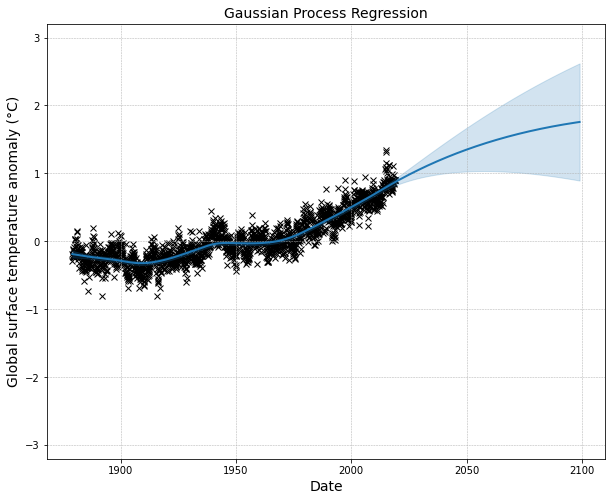

In [18]:
fig = plt.figure(figsize=(10,8))
plt.ylim(-3.2, 3.2)
camera = Camera(fig)

snap = partial(take_picture, X_query=X, data=(X_train, Y_train), fig=fig, camera=camera)

iterations = 10000
snap(sparse_gp)
for step in range(iterations):
    optimization_step()
    if step % 10 == 0:
        elbo = -training_loss().numpy()
    if step < 1000:
        if step % 100 == 0:
            print(f"ELBO at step {step}: {elbo:.2f}")
    else:
        if step % 1000 == 0:
            print(f"ELBO at step {step}: {elbo:.2f}")

    if step % 100 == 0:
        snap(sparse_gp) # Take picture of the state at every 80 iterations for animating

animation = camera.animate(interval=40, repeat=False)
animation.save("figs/timeseries_gp_conditioning.gif", dpi=200)

MovieWriter ffmpeg unavailable; using Pillow instead.


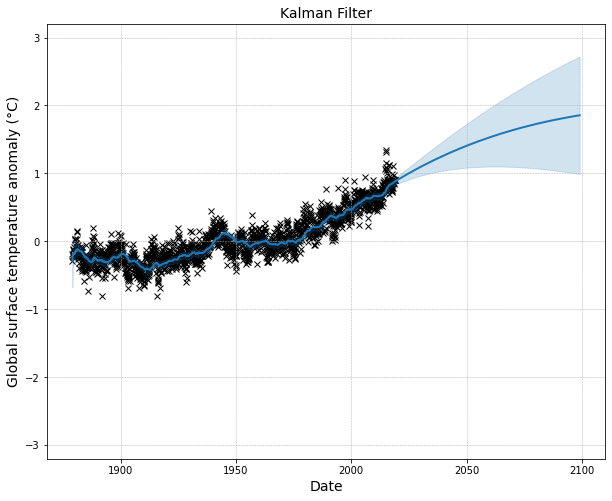

In [19]:
# Kalman Filter approach
fig = plt.figure(figsize=(10,8))
plt.ylim(-3.2, 3.2)
camera = Camera(fig)

f = KalmanFilterSmoother(F, Q, H, R)
config.title = "Kalman Filter"

means = []
variances = []
x_current, P_current = x, P
for n, y in enumerate(Y):
    x_current, P_current = f._filter_update(x_current, P_current, y)
    means.append(x_current[0])
    variances.append(P_current[0, 0])
    x_current, P_current = f._predict(x_current, P_current)
    if n % 50 == 0:
        plot_timeseries(config,
                        plot_args=(X[:n+1], np.array(means).reshape(n+1, 1), np.array(variances).reshape(n+1, 1)),
                        plot_kwargs={"data": (X_train, Y_train), "fig": fig})
        camera.snap()

plot_timeseries(config,
                plot_args=(X, np.array(means)[:, None], np.array(variances)[:, None]),
                plot_kwargs={"data": (X_train, Y_train), "fig": fig})
camera.snap()

animation = camera.animate(interval=40, repeat=False)
animation.save("figs/timeseries_KF_conditioning.gif", dpi=200)
    

## Appendix: The Kalman filter and smoother

In linear state estimation problems, we start by considering a state-space model

\begin{align*}
X_{n+1} &= F X_n + \zeta_n, \quad \zeta_n \sim \mathcal{N}(0, Q), \\
y_n &= H X_n + \eta_n, \quad \eta_n \sim \mathcal{N}(0, R),
\end{align*}

where $(X_n)$ are the latent state variables and $(y_n)$ are observations of $(X_n)$. Our aim is to infer the states $(X_n)$ from $(y_n)$, which can be formulated probabilistically using Bayes' theorem:

\begin{align*}
p(X_{1:N} | y_{1:N}) = \frac{p(y_{1:N} | X_{1:N}) p(X_{1:N})}{p(y_{1:N})},
\end{align*}

where we denoted formally $X_{1:N} := (X_1, \ldots, X_N)$. In practice, we do not estimate the joint states $X_{1:N}$ at once due to the heavy computational cost involved (note: this is what GPR does which is why it is so costly!), instead we update the states $X_n$ sequentially from $n=1$ to $n=N$.

### The Kalman filter
In filtering problems, we update the states $X_n$ sequentially using observations *up until time $n$* and nothing further. In Bayesian terms, Kalman filtering can be seen as solving
\begin{align*}
p(X_{n} | y_{1:n}) &= \frac{p(y_{1:n} | X_{n}) p(X_{n})}{p(y_{1:n})}, \qquad n = 1, \ldots, N,
\end{align*}
If we denote by $\hat{X}_{n|m}$ and $P_{n|m}$, the mean and covariance of the conditional random variable $X_n | y_{1:m}$, the solution to the Kalman filtering problem is given by iterating the following:

1. (Prediction step)
\begin{align*}
\hat{X}_{n | n-1} = F \hat{X}_{n-1|n-1}, \qquad  P_{n|n-1} = F P_{n-1|n-1} F^T + Q.
\end{align*}

2. (Compute the Kalman gain)
\begin{align*}
K_n = P_{n|n-1} H^T(H P_{n|n-1} H^T + R)^{-1}.
\end{align*}

3. (Update step)
\begin{align*}
\hat{X}_{n | n} = \hat{X}_{n | n-1} + K_n (y_n - H \hat{X}_{n | n-1}), \qquad  P_{n|n} = (I - K_n H)P_{n|n-1}.
\end{align*}

Provided the initial state distribution $X_0$ is a Gaussian random variable, this algorithm provides an exact solution to the Kalman filtering problem.

### The Kalman smoother
In smoothing problems, we aim to estimate the states $X_n$ given *all the available observations* until time $N$. That is, solve
\begin{align*}
p(X_{n} | y_{1:N}) &= \frac{p(y_{1:N} | X_{n}) p(X_{n})}{p(y_{1:N})}, \qquad n = 1, \ldots, N.
\end{align*}
We can also think of the smoothing problem as conditioning the filtered distribution $X_{n|n} := X_n|y_{1:n}$ on the future observations $y_{n+1:N}$, since
\begin{align*}
p(X_{n} | y_{1:N}) = p(X_{n} | y_{1:n}, y_{n+1:N}) = p(X_{n|n} | y_{n+1:N}).
\end{align*}
A typical solution to the linear smoothing problem is given by the Rauch-Tung-Striebel (RTS) smoother, which first applies the Kalman filtering algorithm to compute the distributions $X_{n|n}$ for all $n=1, \ldots, N$ and then applying a 'backward pass' to condition the states backwards from time $n=N$ to $n=0$ on future observations. The backward pass is given as follows:

1. (Prediction step)
\begin{align*}
\hat{X}_{n+1 | n} = F \hat{X}_{n|n}, \qquad  P_{n+1|n} = F P_{n|n} F^T + Q.
\end{align*}

2. (Compute the smoother gain)
\begin{align*}
J_n = P_{n|n} H^T P_{n+1|n}^{-1}.
\end{align*}

3. (Update step)
\begin{align*}
\hat{X}_{n | N} = \hat{X}_{n | n} + J_n (\hat{X}_{n+1 | N} - \hat{X}_{n+1 | n}), \qquad  P_{n|N} = P_{n|n} + J_n(P_{n+1|N} - P_{n+1|n})J_n^T.
\end{align*}

Just like the Kalman filter, the RTS smoother provides an exact solution to the smoothing problem when $X_0$ is Gaussian.